In [8]:
import sys
import h5py
from TimeseriesGenerator import TimeseriesGenerator
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, Conv1D
from keras.models import Model
from keras.models import Model
from keras.optimizers import Adam
from tensorflow import keras
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import scipy.signal as sp
import glob
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


# Hyperparameters and model configuration


# load H

In [2]:
runs = 'BCD'
H_bp = np.empty((0,94,7), float)
for i_run, run in enumerate(runs):
    mat_fname = '/scratch/users/wx2203/cmdata/1/H_run'+run+'_stim_1.mat'
    f_n = h5py.File(mat_fname,'r')
    spectrum = np.array(f_n['spectrum'])
    spectrum_string = [None] *spectrum.shape[1]
    for i in range(spectrum.shape[1]):
        spectrum_string[i] = '{:.2f}_{:.2f}hz'.format(spectrum[0,i],spectrum[1,i])
    IDX_sorted = np.array(f_n['IDX_sorted'])
    temp = np.zeros([11960,94,spectrum.shape[1]])
    for i in range(spectrum.shape[1]):
        temp[:,:,i]=np.array(f_n[f_n['H_bp']['x'][i,0]])
    H_bp = np.append(H_bp,temp,axis=0)
    H_hilbert = np.abs(sp.hilbert(H_bp, N=None, axis=0))
del temp

# load corr latent and VAE decoder

In [3]:
class VAE(nn.Module):
    def __init__(self,hparam,fc_units):
        super(VAE, self).__init__()
        self.hparam = hparam
        self.fc_units = fc_units
        

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(8836, self.fc_units)
        self.fc_bn1 = nn.BatchNorm1d(self.fc_units)
        self.fc21 = nn.Linear(self.fc_units, self.hparam['n_latents'])
        self.fc22 = nn.Linear(self.fc_units, self.hparam['n_latents'])

        # Sampling vector
        self.fc3 = nn.Linear(self.hparam['n_latents'], self.fc_units)
#         self.fc_bn3 = nn.BatchNorm1d(self.hparam['n_latents'])
        self.fc_bn3 = nn.BatchNorm1d(self.fc_units)
        self.fc4 = nn.Linear(self.fc_units,  8836)
        self.fc_bn4 = nn.BatchNorm1d( 8836)

        self.relu = nn.ReLU()

    def encode(self, x):

        # calculate latent vectors
        fc1 = self.relu(self.fc_bn1(self.fc1(x)))
        # mu and std
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        # sample from latent vectors
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))#.view(-1, 8836)

        return fc4

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
# load previously saved model
hparam = {'n_latents':20}
fc_units = 400
VAE_model = VAE(hparam=hparam,fc_units=fc_units)#.cuda()
optimizer = optim.Adam(VAE_model.parameters(), lr=1e-3)


checkpoint = torch.load('/home/wx2203/STCS/trash/trash3/epoch_59.pth')
VAE_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
VAE_model.eval()

VAE(
  (fc1): Linear(in_features=8836, out_features=400, bias=True)
  (fc_bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc_bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=400, out_features=8836, bias=True)
  (fc_bn4): BatchNorm1d(8836, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [5]:
temp = h5py.File('/home/wx2203/STCS/z_cm125_1.hdf5','r')
z = temp['z']
ss = H_hilbert.shape
data_gen = TimeseriesGenerator(H_hilbert.reshape((ss[0],ss[1]*ss[2])), 
                               z,stride = 5,sampling_rate=2,
                               length=80,batch_size=100000) 
x , y = data_gen[0]
print(x.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)
print(X_train.shape, X_test.shape , y_train.shape, y_test.shape )

(7160, 40, 658) (7160, 40, 20)
(6444, 40, 658) (716, 40, 658) (6444, 40, 20) (716, 40, 20)


# Conv+LSTM+VAE decoder
network architecture is as follow

![](https://tva1.sinaimg.cn/large/007S8ZIlgy1gfgt7ufos0j30x50u0gzu.jpg)

In [7]:
batch_size = 64
num_input_features = X_train.shape[-1]
num_output_features =y_train.shape[-1]

In [23]:
input_layer = Input(shape=(None, num_input_features))
conv1 = Conv1D(filters=num_input_features*2,
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
lstm1 = Bidirectional(LSTM(50, return_sequences=True))(conv1)
lstm2 = Bidirectional(LSTM(50, return_sequences=True))(lstm1)
output_layer = Dense(num_output_features)(lstm2)
clstm_model = Model(inputs=input_layer, outputs=output_layer)

In [24]:
clstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 658)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 1316)        2599100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         546800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
dense_1 (Dense)              (None, None, 20)          2020      
Total params: 3,208,320
Trainable params: 3,208,320
Non-trainable params: 0
_________________________________________________________________


In [32]:
clstm_model.compile(Adam(), loss='mean_absolute_error')
history = clstm_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    validation_split=0.1)

Train on 5799 samples, validate on 645 samples
Epoch 1/50
5799/5799 [==============================] - 48s 8ms/step - loss: 0.4539 - val_loss: 0.4338
Epoch 2/50
5799/5799 [==============================] - 44s 8ms/step - loss: 0.4147 - val_loss: 0.4316
Epoch 3/50
5799/5799 [==============================] - 44s 8ms/step - loss: 0.4131 - val_loss: 0.4333
Epoch 4/50
5799/5799 [==============================] - 45s 8ms/step - loss: 0.4113 - val_loss: 0.4275
Epoch 5/50
5799/5799 [==============================] - 44s 8ms/step - loss: 0.4088 - val_loss: 0.4285
Epoch 6/50
5799/5799 [==============================] - 45s 8ms/step - loss: 0.4078 - val_loss: 0.4265
Epoch 7/50
5799/5799 [==============================] - 45s 8ms/step - loss: 0.4050 - val_loss: 0.4218
Epoch 8/50
5799/5799 [==============================] - 45s 8ms/step - loss: 0.4009 - val_loss: 0.4186
Epoch 9/50
5799/5799 [==============================] - 50s 9ms/step - loss: 0.4002 - val_loss: 0.4193
Epoch 10/50
5799/5799 [===

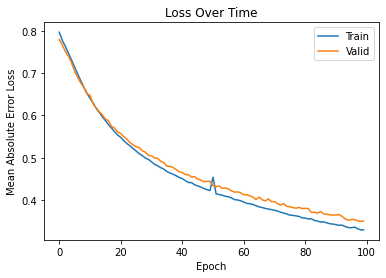

In [39]:
plt.plot(overall_loss)
plt.plot(overall_valloss)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [245]:
yhat = clstm_model.predict(X_test)
yhat.shape

(716, 40, 20)

Text(0.5, 0, 'time')

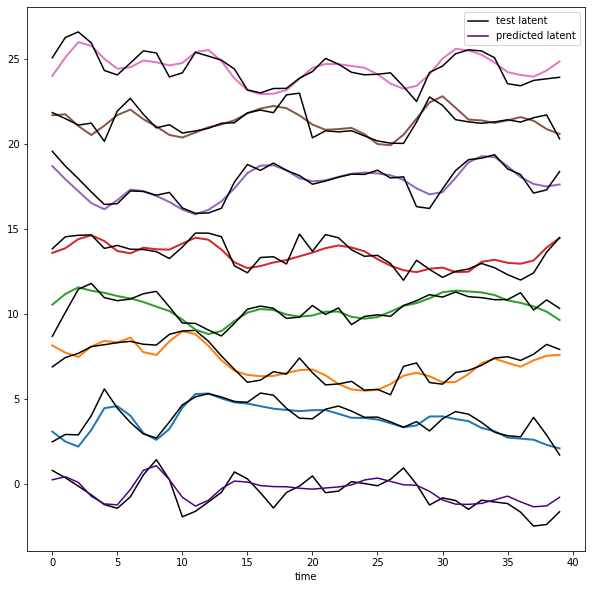

In [246]:
plt.figure(figsize=(10,10))
i_region = 10
for i_latent in range(1,8):
    plt.plot(yhat[i_region,:,i_latent]+i_latent*3.5, linewidth=2)
    plt.plot(y_test[i_region,:,i_latent]+i_latent*3.5,color='black')

plt.plot(y_test[i_region,:,0]+0*3.5,color='black',label='test latent')
plt.plot(yhat[i_region,:,0]+0*3.5, color='indigo',label = 'predicted latent')
plt.legend()
plt.xlabel('time')

In [70]:
clstm_model.save('my_model_june2')

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model('my_model')


# Now do something more

In [122]:
with torch.no_grad():
    decoded_data = VAE_model.decode(torch.from_numpy(y_concat).float())
    decoded_data = decoded_data.numpy().reshape((-1,94,94))
    predicted_data = VAE_model.decode(torch.from_numpy(yhat_concat).float())
    predicted_data = predicted_data.numpy().reshape((-1,94,94))

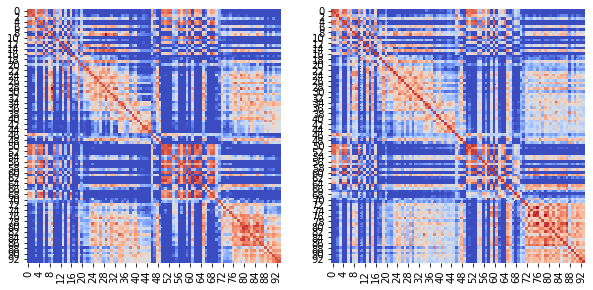

In [124]:
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.heatmap(decoded_data[20,:,:],
            square=True,cmap='coolwarm',cbar=False)
plt.subplot(122)
sns.heatmap(predicted_data[20,:,:],
            square=True,cmap='coolwarm',cbar=False)

In [146]:
# loading original ground truth cc
mat_fname = '/scratch/users/wx2203/cmdata/cc_no_ds_ww_11_94regions_cm125.mat'
f = h5py.File(mat_fname,'r')
cc_no_ds = np.empty((0,8836), float)
for i in range(3):
    a = f['cc_no_ds'][i,0]
    temp = np.array(f[a])
    temp = temp[5:-14,:] # trim first5 and last 15 frames
    cc_no_ds = np.append(cc_no_ds,temp,axis=0) #(11960*3, 8836)

In [148]:
data_gen = TimeseriesGenerator(cc_no_ds, 
                               np.zeros(cc_no_ds.shape),stride = 80,sampling_rate=2,
                               length=80,batch_size=100000) 

In [151]:
x,y = data_gen[0]
ss=x.shape
cc_concat = np.empty((0,ss[2]),float)
for i in range(ss[1]):
    cc_concat = np.append(cc_concat,x[:,i,:],axis=0)
cc_concat = cc_concat.reshape((-1,94,94))

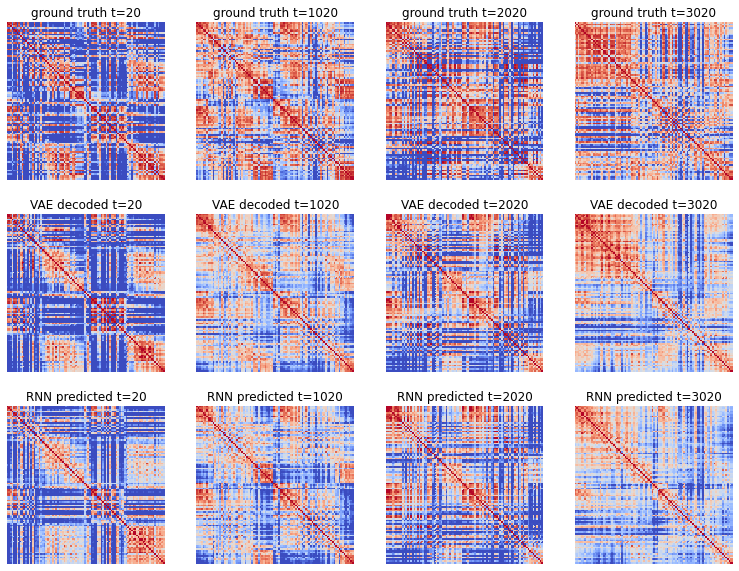

In [241]:
timeframes = range(20,4020,1000)
plt.figure(figsize=(13,10))
for i_tf,timeframe in enumerate(timeframes):
    plt.subplot(3,4,i_tf+1)
    sns.heatmap(cc_concat[timeframe,:,:],
                square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
               xticklabels=False, yticklabels=False)
    plt.title('ground truth t='+str(timeframe))
    plt.subplot(3,4,i_tf+5)
    sns.heatmap(decoded_data[timeframe,:,:],
                square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
               xticklabels=False, yticklabels=False)
    plt.title('VAE decoded t='+str(timeframe))
    plt.subplot(3,4,i_tf+9)
    sns.heatmap(predicted_data[timeframe,:,:],
                square=True,cmap='coolwarm',vmin=0,vmax=1,cbar=False,
               xticklabels=False, yticklabels=False)
    plt.title('RNN predicted t='+str(timeframe))


**frequency band operation**

Text(0.5, 1.0, 'original')

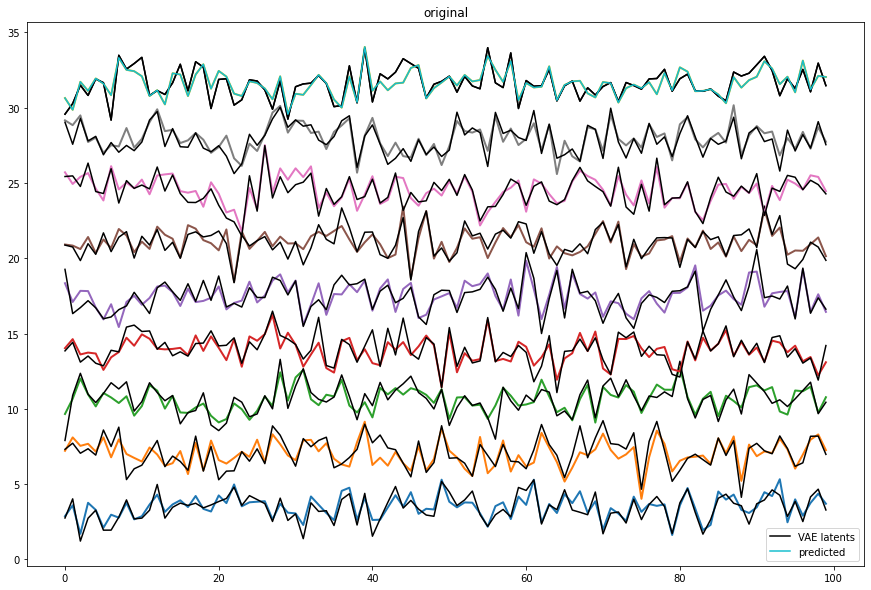

In [250]:
x , y = data_gen[0]
# print(x.shape,y.shape)
# x = x.reshape((448,40,94,7))
# x[:,:,:,1]=0
# x = x.reshape((448,40,94*7))
yhat = clstm_model.predict(x)
ss = yhat.shape
y_concat = np.empty((0,ss[2]),float)
yhat_concat = np.empty((0,ss[2]),float)
for i in range(ss[1]):
    y_concat = np.append(y_concat,y[:,i,:],axis=0)
    yhat_concat = np.append(yhat_concat,yhat[:,i,:],axis=0)
MSE = mean_squared_error(yhat_concat,y_concat)
pd_MSE = pd.DataFrame({'original':[MSE]})
plt.figure(figsize=(15,10))
for i_latent in range(1,10):
    plt.plot(yhat_concat[1300:1400,i_latent]+i_latent*3.5, linewidth=2)
    plt.plot(y_concat[1300:1400,i_latent]+i_latent*3.5,color='black')
plt.plot(y_concat[1300:1400,i_latent]+i_latent*3.5,color='black',label='VAE latents')
plt.plot(yhat_concat[1300:1400,i_latent]+i_latent*3.5,label='predicted')
plt.legend()
plt.title('original')

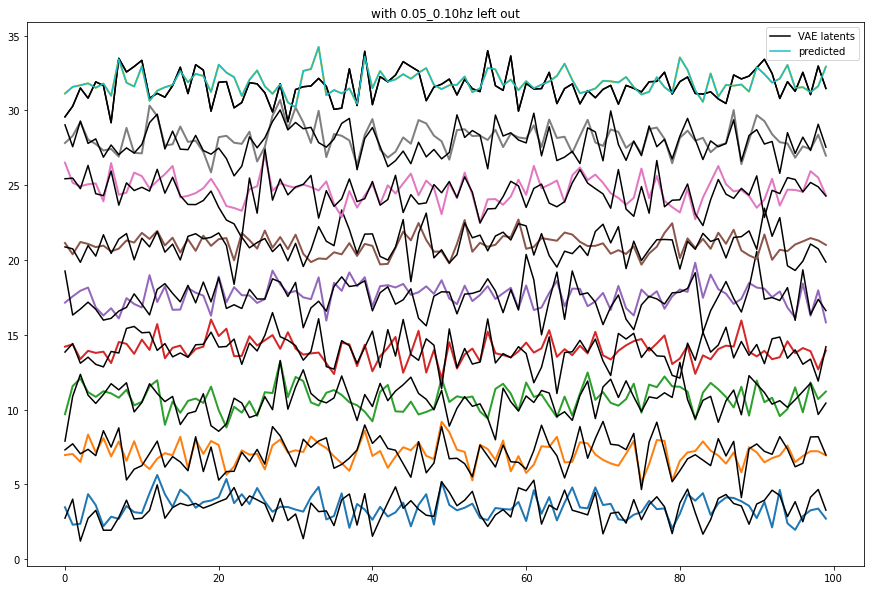

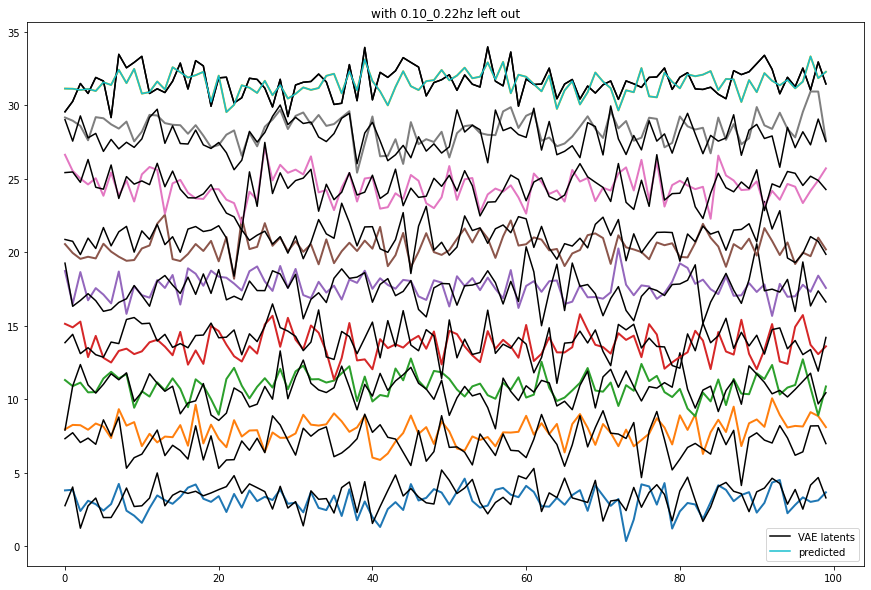

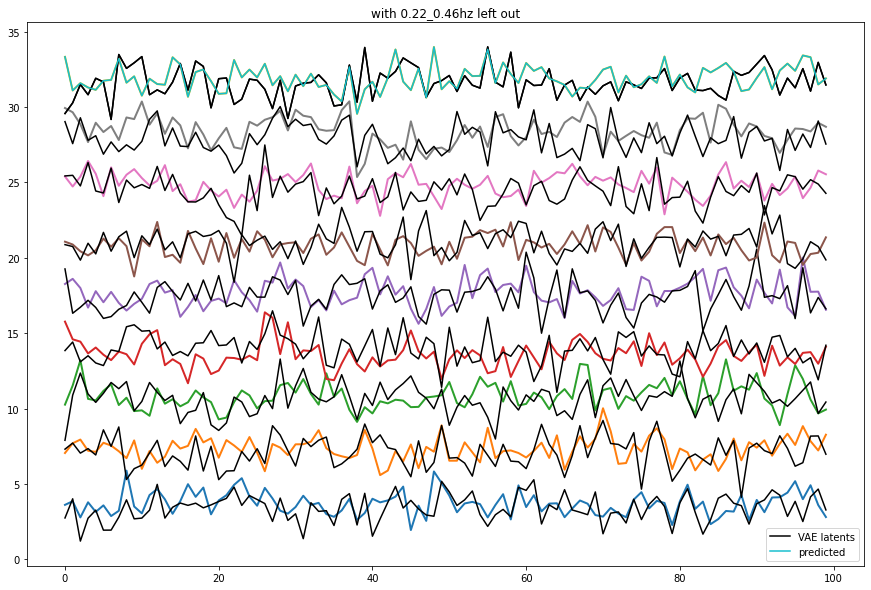

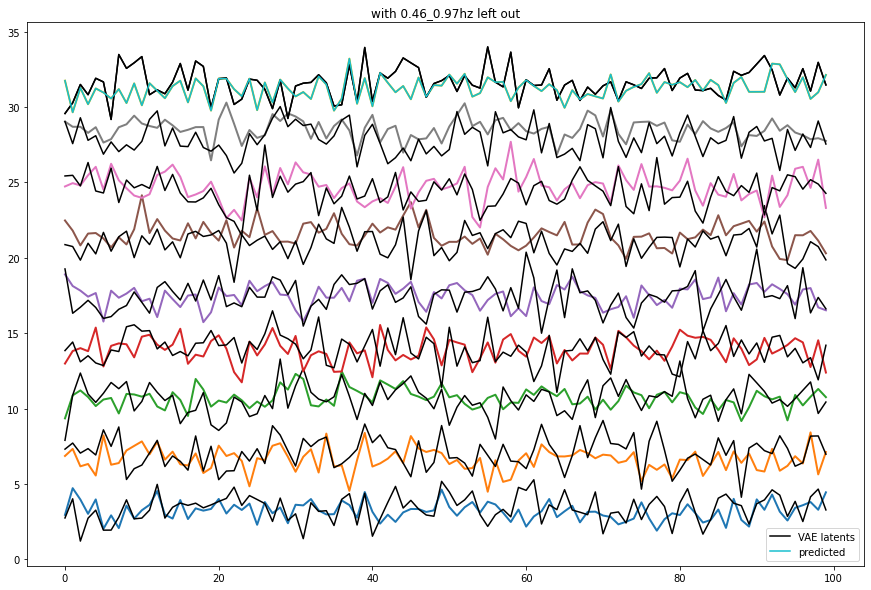

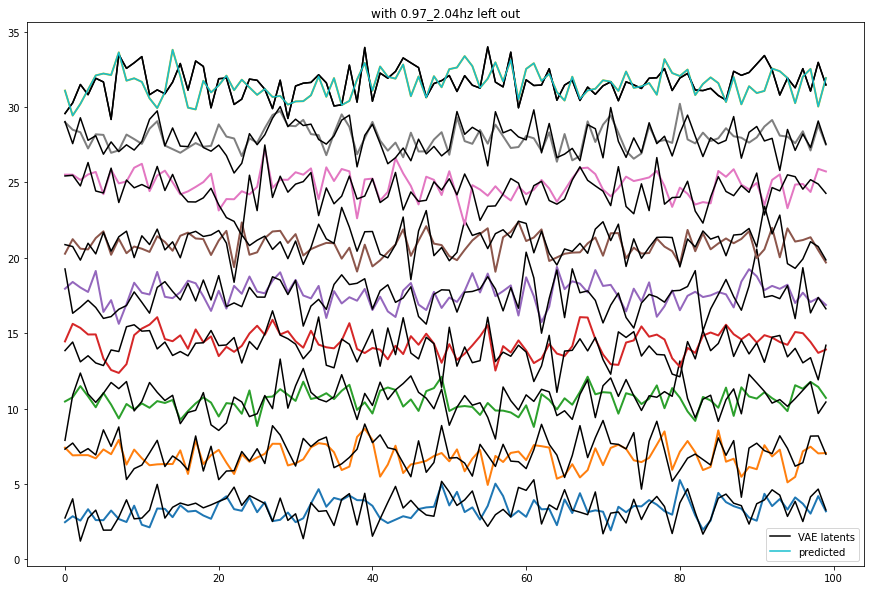

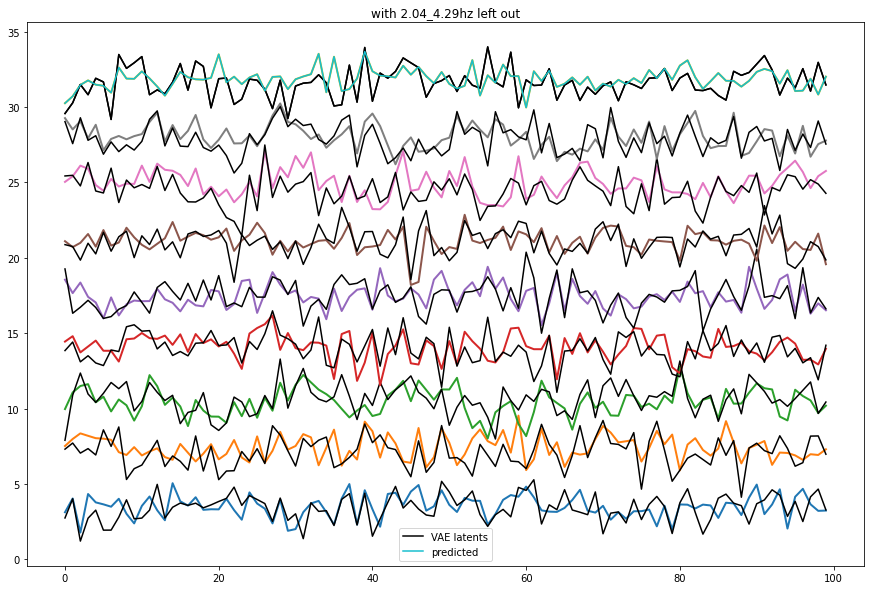

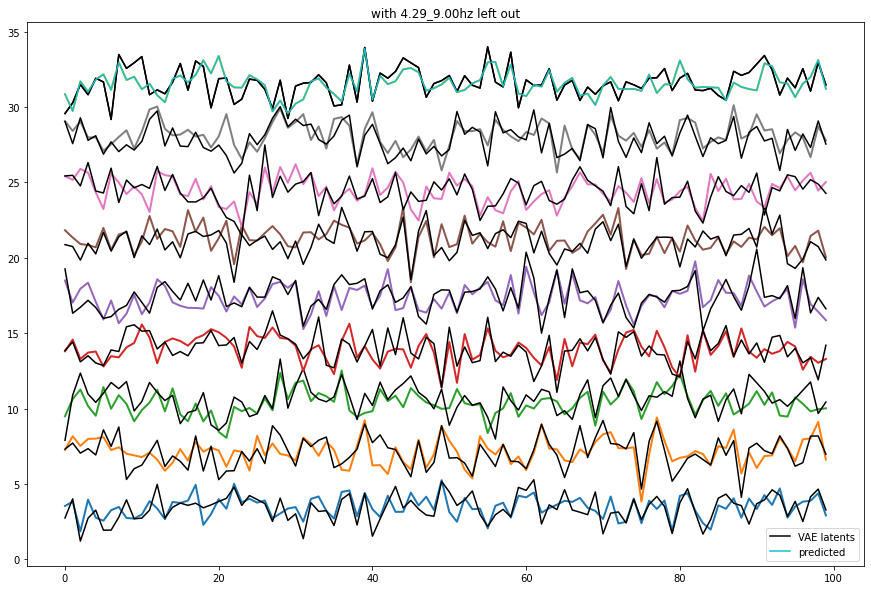

In [251]:
for i_f, freq_band in enumerate(spectrum_string):
    x , y = data_gen[0]
    # print(x.shape,y.shape)
    x = x.reshape((448,40,94,7))
    x[:,:,:,i_f]=0
    x = x.reshape((448,40,94*7))
    yhat = clstm_model.predict(x)
    ss = yhat.shape
    y_concat = np.empty((0,ss[2]),float)
    yhat_concat = np.empty((0,ss[2]),float)
    for i in range(ss[1]):
        y_concat = np.append(y_concat,y[:,i,:],axis=0)
        yhat_concat = np.append(yhat_concat,yhat[:,i,:],axis=0)
    MSE = mean_squared_error(yhat_concat,y_concat)
    pd_MSE = pd_MSE.join(pd.DataFrame({freq_band:[MSE]}))
    plt.figure(figsize=(15,10))
    for i_latent in range(1,10):
        plt.plot(yhat_concat[1300:1400,i_latent]+i_latent*3.5, linewidth=2)
        plt.plot(y_concat[1300:1400,i_latent]+i_latent*3.5,color='black')
    plt.plot(y_concat[1300:1400,i_latent]+i_latent*3.5,color='black',label='VAE latents')
    plt.plot(yhat_concat[1300:1400,i_latent]+i_latent*3.5,label='predicted')
    plt.legend()
    plt.title('with '+freq_band+' left out')

In [252]:
print(pd_MSE)

   original  0.05_0.10hz  0.10_0.22hz  0.22_0.46hz  0.46_0.97hz  0.97_2.04hz  \
0  0.205927     0.790501     1.212473     1.162518     1.147111     1.011338   

   2.04_4.29hz  4.29_9.00hz  
0     1.014463     0.556798  


Text(0, 0.5, 'MSE')

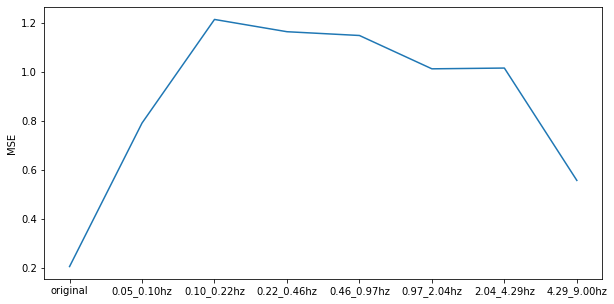

In [257]:
plt.figure(figsize=(10,5))
plt.plot(pd_MSE.iloc[0,:])
plt.ylabel('MSE')